In [1]:
import sys

sys.path.append("/Users/leo/Desktop/Thesis/utils/")
sys.path.append("/Users/leo/Desktop/Thesis/models/")

import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torchvision
from torchvision.models import mobilenet_v3_large
from torchvision.models import MobileNet_V3_Large_Weights as weights
import torchvision.transforms as transforms
from torchinfo import summary
from helper_functions import MBNV3_build, delete_ds_store, plot_metrics, test, train, set_device
from CBAM import _CBAM

#setting the seed for reproducibility
torch.manual_seed(42)

In [2]:
prms = {
    "model": mobilenet_v3_large,
    "weights": weights.IMAGENET1K_V2,
    "module": _CBAM,
    "module_alias": "CBAM",
    "data_path": "../data/faces_50/",
    "batch_size": 32,
    "img_size": 128,
    "num_classes": 50,
    "epochs": 2,
    "learning_rate": 0.001,
    "device": set_device(),
}
prms["model_save_path"] = f"./output/{prms['module_alias']}_{prms['data_path'].split('/')[-2]}.pth"

delete_ds_store(prms["data_path"])

In [10]:
train_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

test_transform = transforms.Compose([
    transforms.Resize((prms["img_size"], prms["img_size"])),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [11]:
#Accessing the data
train_data = torchvision.datasets.ImageFolder(prms["data_path"] + "train/", transform=train_transform)
val_data = torchvision.datasets.ImageFolder(prms["data_path"] + "val/", transform=test_transform)
test_data = torchvision.datasets.ImageFolder(prms["data_path"] + "test/", transform=test_transform)

#Creating the data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=prms["batch_size"], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size=prms["batch_size"], shuffle=False)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=prms["batch_size"], shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


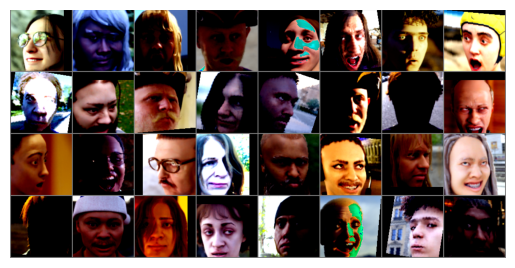

In [12]:
#display random images from the dataset
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    #drop axis labels
    plt.axis('off')
    plt.show()

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))

In [13]:
#define model
model = MBNV3_build(prms["num_classes"],prms["model"],prms["weights"],prms["module"],prms["device"])

# Loss and optimizer
criterion = nn.CrossEntropyLoss().to(prms["device"])
optimizer = torch.optim.Adam(model.parameters(), lr=prms["learning_rate"])

In [14]:
summary(model, input_size=(1, 3, prms["img_size"], prms["img_size"]),
        col_names = ["input_size", "output_size", "num_params", "kernel_size", "mult_adds", "trainable"],
        col_width = 20,
        row_settings = ["var_names"],
        depth=8)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Kernel Shape         Mult-Adds            Trainable
MobileNetV3 (MobileNetV3)                                    [1, 3, 128, 128]     [1, 50]              --                   --                   --                   Partial
├─Sequential (features)                                      [1, 3, 128, 128]     [1, 960, 4, 4]       --                   --                   --                   Partial
│    └─Conv2dNormActivation (0)                              [1, 3, 128, 128]     [1, 16, 64, 64]      --                   --                   --                   False
│    │    └─Conv2d (0)                                       [1, 3, 128, 128]     [1, 16, 64, 64]      (432)                [3, 3]               1,769,472            False
│    │    └─BatchNorm2d (1)                                  [1, 16, 64, 64]      [1, 16, 64, 64]      (32)                 --      

In [15]:
#train the model
train_losses, train_acc, val_losses, val_acc = train(model, train_loader, val_loader, criterion, optimizer, hyper_params = prms, verbose = 2)

#plot the training and validation metrics
plot_metrics(train_losses, train_acc, val_losses, val_acc)

100%|██████████| 18/18 [00:01<00:00,  9.04it/s]


Epoch: 01 | Epoch Time: 0m 21s
	Train Loss: 3.624 | Train Acc: 11.16%
	 Val. Loss: 3.674 |  Val. Acc: 8.18%
Best Accuracy Achieved: 8.18% on epoch 01


 32%|███▏      | 29/90 [00:06<00:13,  4.68it/s]

In [9]:
#test the model
test(model, test_loader, criterion, hyper_params = prms)

Test loss: 1.417.. 
Test accuracy: 0.610
Test Time: 0m 1s


(1.4173178231716157, tensor(0.6100, device='mps:0'))